## Approach

### Data
- upsample minority classes
- upsample TMAs in training set
- both WSIs and TMAs at 20X magnification

### Model
- CTransPath as feature extractor
- MLP with added dropout as decoder
- Train MLP with slide-level labels (semi-supervised) to predict one of five classes

In [1]:
from timm.models.layers.helpers import to_2tuple
import timm
import torch.nn as nn
import torch
import torch.backends.cudnn as cudnn

from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import balanced_accuracy_score

import os
import pandas as pd
import openslide
from PIL import Image
import numpy as np
import random
import time
import warnings

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
DATA_DIR = 'Data/'

args = pd.Series({
    'batch_size_per_gpu' : 2048,
    'num_workers': 8,
    'image_dir': os.path.join(DATA_DIR, 'train_images'),
    'model_name': 'CTRansPath_MLP_20x',
    'patch_df': 'train_patches_20x',
    'mag': '20X',
    'train_val_split': 0.90,
})

train_on_all_data = False

In [3]:
device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')    

CTransPath from https://github.com/Xiyue-Wang/TransPath

Make sure to insure specified version of timm.

In [4]:
class ConvStem(nn.Module):

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=768, norm_layer=None, 
                 flatten=True, output_fmt=None):
        super().__init__()

        assert patch_size == 4
        assert embed_dim % 8 == 0

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.flatten = flatten


        stem = []
        input_dim, output_dim = 3, embed_dim // 8
        for l in range(2):
            stem.append(nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=2, padding=1, bias=False))
            stem.append(nn.BatchNorm2d(output_dim))
            stem.append(nn.ReLU(inplace=True))
            input_dim = output_dim
            output_dim *= 2
        stem.append(nn.Conv2d(input_dim, embed_dim, kernel_size=1))
        self.proj = nn.Sequential(*stem)

        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        #print(x.shape)
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x)
        if self.flatten:
            x = x.flatten(2).transpose(1, 2)  # BCHW -> BNC
        x = self.norm(x)
        return x

def ctranspath():
    model = timm.create_model('swin_tiny_patch4_window7_224', embed_layer=ConvStem, pretrained=False)
    return model

In [5]:
def feature_extraction(feature_model, image):
    #feature_model.eval()
    
    #image = image.cuda(non_blocking=True)
    
    with torch.no_grad():
        output = feature_model(image)
        
    return output

### Construct data loader

Load data

In [6]:
patch_df = pd.read_csv(f'{args.patch_df}.csv', index_col=0)

train_df = pd.read_csv(os.path.join(DATA_DIR, 'train_hot.csv'), index_col=0)

Using 5 classes only so -1 from class

In [7]:
train_df['label_cat'] = train_df['label_cat'] - 1

Subsample patches for WSIs

In [8]:
wsi_ids = train_df[train_df.is_tma==False].image_id.values

tma_ids = train_df[train_df.is_tma==True].image_id.values
sub_patch_df = patch_df[patch_df.image_id.isin(tma_ids)].reset_index(drop=True)

In [9]:
max_tiles = 10000

for wsi_id in wsi_ids:
    # sample min(#, 10000) tiles per WSI without replacement
    
    wsi_id_patches = patch_df[patch_df.image_id==wsi_id]
    
    if len(wsi_id_patches) > max_tiles:
        wsi_id_patches = wsi_id_patches.sample(n=max_tiles, replace=False, axis=0)
    
    # add sample to sub_patch_df
    sub_patch_df = pd.concat([sub_patch_df, wsi_id_patches], ignore_index=True)

Define transforms

In [10]:
class MyRotateTransform:
    def __init__(self, angles):  #: Sequence[int]):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle)
    

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(.1, 0.25, 0.5, 0.25),
    transforms.GaussianBlur(kernel_size=(9, 9)),
    transforms.RandomAdjustSharpness(sharpness_factor=2., p=0.2),
    transforms.RandomAutocontrast(p=0.5),
    MyRotateTransform(angles=[-90, 0, 90, 180]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Define dataset and data loader

In [11]:
class PatchDataset(Dataset):
    def __init__(self, patch_df, label_df, image_folder, transform=None, patch_size=256, return_id=False,
                mag='20X'):
        self.patch_df = patch_df
        self.label_df = label_df
        self.image_folder = image_folder
        self.transform = transform
        self.patch_size = patch_size
        self.return_id = return_id
        self.mag = mag
        
        
    def __len__(self):
        return len(self.patch_df)
    
    
    def __getitem__(self, idx):
        #print('           idx:', idx)
        patch_info = self.patch_df.loc[idx] # using loc, so using name of index not ordered position
        x, y = patch_info['x_coord'], patch_info['y_coord']
        image_id = patch_info['image_id']
        
        wsi = openslide.OpenSlide(os.path.join(self.image_folder, f"{image_id}.tif"))
        wsi_size = wsi.dimensions
        
        if self.mag == '10X':
            level = 2 if is_tma_image(image_id) else 1
        elif self.mag == '20X':
            level = 1 if is_tma_image(image_id) else 0
        else:
            level = 0
        patch = wsi.read_region((x, y), level=level, size=(self.patch_size, self.patch_size))
        patch = np.array(patch)[..., :3]
        
        
        # shape torch.Size([batch_size, 256, 256, 3])
        
        if self.transform is not None:
            pil_img = Image.fromarray(patch)
            patch = self.transform(pil_img) # pil_img
        
        label = self.label_for_id(image_id)        
    
        if self.return_id:
            return patch, label, image_id
        else:
            return patch, label
    
        
    def label_for_id(self, image_id):
        return self.label_df[self.label_df['image_id']==image_id]['label_cat'].iloc[0]
        
def is_tma_image(image_id, label_df=train_df):
    return label_df[label_df.image_id==image_id].is_tma.item()

### Train MLP with dropout to predict label from CTransPath features

Split into train and validation based off labels

In [12]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
#torch.backends.cudnn.deterministic = True

full_ids = train_df.image_id.unique()
n_train_examples = int(len(full_ids) * args.train_val_split)
n_valid_examples = len(full_ids) - n_train_examples

# random select validation, training are all others
train_idxs, valid_idxs = torch.utils.data.random_split(full_ids, [n_train_examples, n_valid_examples])

print(f'Number of training examples: {len(train_idxs)}')
print(f'Number of validation examples: {len(valid_idxs)}')

train_ids = train_df.iloc[train_idxs.indices].image_id.values
valid_ids = train_df.iloc[valid_idxs.indices].image_id.values

train_data = sub_patch_df[sub_patch_df.image_id.isin(train_ids)].reset_index()
valid_data = sub_patch_df[sub_patch_df.image_id.isin(valid_ids)].reset_index()

Number of training examples: 484
Number of validation examples: 54


Check label counts of training and validation sets

In [13]:
# Training set
print(train_df[train_df.image_id.isin(train_ids)].label.value_counts())

HGSC    196
EC      114
CC       88
LGSC     45
MC       41
Name: label, dtype: int64


In [14]:
# Validation set
if not train_on_all_data:
    print(train_df[train_df.image_id.isin(valid_ids)].label.value_counts())

HGSC    26
CC      11
EC      10
MC       5
LGSC     2
Name: label, dtype: int64


### Upsample TMAs

In [15]:
train_tmas = list(filter(lambda img_id: img_id in tma_ids, train_ids))

tma_upsample_factor = 100

for tma_id in train_tmas:
    print(train_data.shape)
    tma_id_patches = train_data[train_data.image_id==tma_id]
    for i in range(tma_upsample_factor-1):
        train_data = pd.concat([train_data, tma_id_patches], ignore_index=True)

#train_data.to_csv('upsampled_tma_train.csv', index=False)

#train_data = pd.read_csv('upsampled_tma_train.csv', index_col=0)

(4540758, 4)
(4550559, 4)
(4562439, 4)
(4572438, 4)
(4586892, 4)
(4599762, 4)
(4611741, 4)
(4623324, 4)
(4636095, 4)
(4641342, 4)
(4655004, 4)
(4665795, 4)
(4675398, 4)
(4690941, 4)
(4707078, 4)
(4718661, 4)
(4727571, 4)
(4742421, 4)
(4753509, 4)
(4766478, 4)
(4779744, 4)
(4790040, 4)
(4801623, 4)
(4810830, 4)


### Upsample minority classes

In [16]:
def upsample_minority_class(minor_lbl, lbl_df, train_ids, train_data):
    
    train_data_lbls = lbl_df[lbl_df.image_id.isin(train_ids)]
    
    minor_ids = train_data_lbls[train_data_lbls.label_cat==minor_lbl].image_id.values
    
    counts = train_data_lbls.label_cat.value_counts()
    upsample_factor = int(np.floor(max(counts) / counts[minor_lbl]))
    print(f'Upsampling {upsample_factor} times for label {minor_lbl}')
    
    print(f'Initial train data: {len(train_data)}')
    if upsample_factor > 1:
        minor_patches = train_data[train_data.image_id.isin(minor_ids)]
        print(f'Adding {len(minor_patches)} patches each time')
        for i in range(upsample_factor-1):
            train_data = pd.concat([train_data, minor_patches], ignore_index=True)
        print(f'Final train data: {len(train_data)}')
    
    return train_data

In [17]:
upsampled_train_data = train_data.copy()
for lbl in range(5):
    upsampled_train_data = upsample_minority_class(lbl, train_df, train_ids, upsampled_train_data)

Upsampling 4 times for label 0
Initial train data: 4816275
Adding 409273 patches each time
Final train data: 6044094
Upsampling 4 times for label 1
Initial train data: 6044094
Adding 446562 patches each time
Final train data: 7383780
Upsampling 1 times for label 2
Initial train data: 7383780
Upsampling 2 times for label 3
Initial train data: 7383780
Adding 890600 patches each time
Final train data: 8274380
Upsampling 1 times for label 4
Initial train data: 8274380


### Define data loaders

In [18]:
# Separate data loaders

train_patch_dataset = PatchDataset(patch_df=upsampled_train_data, label_df=train_df, 
                                   image_folder=args.image_dir, transform=train_transform, mag=args.mag)
        
train_loader = DataLoader(train_patch_dataset, batch_size=args.batch_size_per_gpu, 
                                           shuffle=True, num_workers=args.num_workers, 
                                           pin_memory=True, sampler=None)

if not train_on_all_data:
    valid_patch_dataset = PatchDataset(patch_df=valid_data, label_df=train_df, 
                                       image_folder=args.image_dir, transform=val_transform, mag=args.mag)
            
    valid_loader = DataLoader(valid_patch_dataset, batch_size=args.batch_size_per_gpu, 
                                               shuffle=False, num_workers=args.num_workers, 
                                               pin_memory=True, sampler=None)

In [19]:
len(train_loader)

4041

In [20]:
if not train_on_all_data:
    print(len(valid_loader))

257


### Define MLP with dropout

Original from https://colab.research.google.com/github/bentrevett/pytorch-image-classification/blob/master/1_mlp.ipynb#scrollTo=VGDeNGLhREwf

In [21]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 384)
        self.hidden_fc1 = nn.Linear(384, 96)
        self.output_fc = nn.Linear(96, output_dim)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))
        
        h_1 = self.dropout(h_1)

        # h_1 = [batch size, 384]

        h_2 = F.relu(self.hidden_fc1(h_1))
        
        h_2 = self.dropout(h_2)

        # h_2 = [batch size, 96]

        y_pred = self.output_fc(h_2)

        # y_pred = [batch size, output dim]

        return self.softmax(y_pred), h_2

Set up for training the model

In [22]:
warnings.filterwarnings('ignore')

# ============ define feature model ============
feature_model = ctranspath()
feature_model.head = nn.Identity()
# load weights to evaluate
td = torch.load(r'ctranspath.pth')
feature_model.load_state_dict(td['model'], strict=True)

#embed_dim = model.embed_dim # returns 96 for initial conv layer but actually might be 768
embed_dim = feature_model.layers[-1].blocks[-1].mlp.fc2.out_features # this is 768
feature_model = nn.DataParallel(feature_model)


feature_model = feature_model.to(device)
feature_model.eval()


print(f"CTransPath model built.")

# ============ define MLP model head ============
mlp = MLP(embed_dim, 5)
mlp = nn.DataParallel(mlp)
mlp = mlp.to(device)


# ============ define optimisers ============
optimizer = optim.Adam(mlp.parameters())
criterion = nn.CrossEntropyLoss().to(device)

CTransPath model built.


In [23]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def calculate_balanced_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    return balanced_accuracy_score(y.detach().cpu().numpy(), top_pred.detach().cpu().numpy())

def train(feature_model, model_head, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    epoch_bacc = 0
    
    model_head.train()
    feature_model.eval()

    for (img, lbl) in tqdm(iterator, desc="Training", leave=False):
        
        img = img.to(device)
        lbl = lbl.to(device)

        optimizer.zero_grad()

        features = feature_extraction(feature_model, img)
        pred, _ = model_head(features)

        loss = criterion(pred, lbl)

        acc = calculate_accuracy(pred, lbl)
        bacc = calculate_balanced_accuracy(pred, lbl)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_bacc += bacc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_bacc / len(iterator)

def evaluate(feature_model, model_head, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    epoch_bacc = 0
    
    model_head.eval()
    feature_model.eval()

    with torch.no_grad():

        for (img, lbl) in tqdm(iterator, desc="Evaluating", leave=False):
            
            img = img.to(device)
            lbl = lbl.to(device)
            
            features = feature_extraction(feature_model, img)
            pred, _ = model_head(features)

            loss = criterion(pred, lbl)

            acc = calculate_accuracy(pred, lbl)
            bacc = calculate_balanced_accuracy(pred, lbl)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_bacc += bacc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_bacc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#### Train model

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

EPOCHS = 10

best_valid_loss = float('inf')

train_losses = []
valid_losses = []

warnings.filterwarnings('ignore')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc, train_bacc = train(feature_model, mlp, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc, valid_bacc = evaluate(feature_model, mlp, valid_loader, criterion, device)

    if valid_loss < best_valid_loss:
        # save best epoch model
        print(f'Saving best model at epoch {epoch}')
        best_valid_loss = valid_loss
        torch.save(mlp.state_dict(), f'checkpoint/{args.model_name}.pt')
    
    torch.save(mlp.state_dict(), f'checkpoint/{args.model_name}_epoch_{epoch}.pt')
        
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    log_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s' + '\n' +\
        f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%' +\
        f' | Train bAcc: {train_bacc*100:.2f}%' + '\n' +\
        f'\tVal Loss: {valid_loss:.3f} | Val Acc: {valid_acc*100:.2f}%' +\
        f' | Val bAcc: {valid_bacc*100:.2f}%'
    print(log_str)
    
    log_path = os.path.join(f'checkpoint/{args.model_name}_log.txt')
    with Path(log_path).open("a") as f:
        f.write(log_str + "\n")

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/4041 [00:00<?, ?it/s]

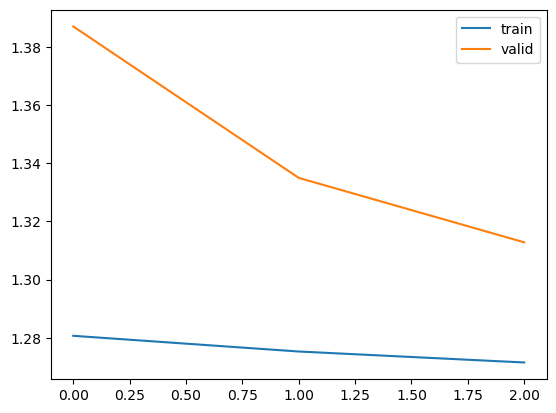

In [72]:
# Plot losses
plt.plot(range(EPOCHS), train_losses, label='train')
plt.plot(range(EPOCHS), valid_losses, label='valid')
plt.legend()
plt.show()

### Explore patch predictions for TMAs (validation set)

In [31]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

valid_patch_dataset = PatchDataset(patch_df=valid_data, label_df=train_df, 
                                   image_folder=args.image_dir, transform=val_transform,
                                         return_id=True)
        
valid_loader = DataLoader(valid_patch_dataset, batch_size=args.batch_size_per_gpu, 
                                           shuffle=False, num_workers=args.num_workers, 
                                           pin_memory=True, sampler=None)

In [32]:
def evaluate_predictions(feature_model, model_head, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    epoch_bacc = 0
    
    ids = []
    preds = []
    lbls = []
        
    model_head.eval()
    feature_model.eval()

    with torch.no_grad():

        for (img, lbl, iid) in tqdm(iterator, desc="Evaluating", leave=False):
            
            img = img.to(device)
            lbl = lbl.to(device)
            
            features = feature_extraction(feature_model, img)
            pred, _ = model_head(features)

            loss = criterion(pred, lbl)

            acc = calculate_accuracy(pred, lbl)
            bacc = calculate_balanced_accuracy(pred, lbl)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_bacc += bacc.item()
            
            ids.extend(iid.detach().cpu().numpy())
            preds.extend(pred.detach().cpu().numpy())
            lbls.extend(lbl.detach().cpu().numpy())
            
    val_loss = epoch_loss / len(iterator)
    val_acc = epoch_acc / len(iterator)
    val_bacc = epoch_bacc / len(iterator)

    print(f'Valid Loss: {val_loss:.3f} | Valid Acc: {val_acc*100:.2f}% |' + 
      f' Valid Balanced Acc: {val_bacc*100:.2f}%')
    
    return ids, preds, lbls

In [33]:
mlp.load_state_dict(torch.load(f'checkpoint/{args.model_name}.pt'))

ids, preds, lbls = evaluate_predictions(feature_model, mlp, valid_loader, criterion, device)

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Valid Loss: 1.324 | Valid Acc: 57.19% | Valid Balanced Acc: 53.53%


Put into dataframe and save

In [34]:
print(len(ids))
print(np.array(preds).shape)
print(len(lbls))

10359
(10359, 5)
10359


In [35]:
pred_df = pd.DataFrame(preds, columns =['pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4'], 
                       dtype = float)
pred_df['label'] = lbls
pred_df['image_id'] = ids

In [36]:
#pred_df.to_csv('PredictionExample.csv')

Explore slide level predictions

In [38]:
import matplotlib.pyplot as plt

def hist_of_preds(image_id, pred_df=pred_df):
    preds = pred_df[pred_df['image_id']==image_id]
    plt.figure(figsize=(8,4))
    plt.hist(preds[['pred_0','pred_1','pred_2','pred_3','pred_4']])
    plt.legend(['pred_0','pred_1','pred_2','pred_3','pred_4'])
    plt.title(f'Image {image_id}, label {preds.label.iloc[0]}')
    plt.show()

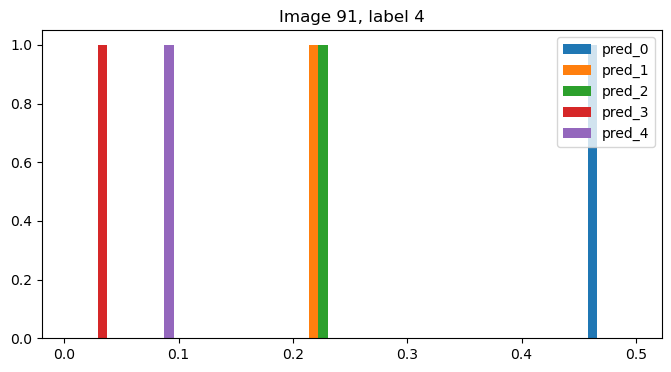

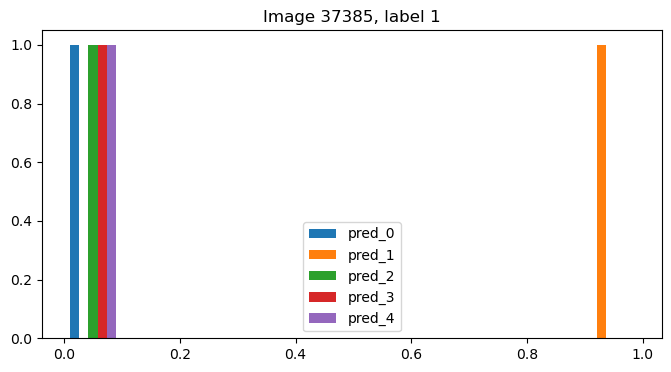

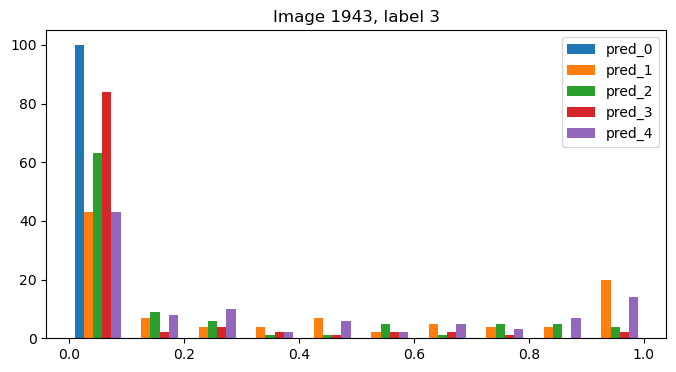

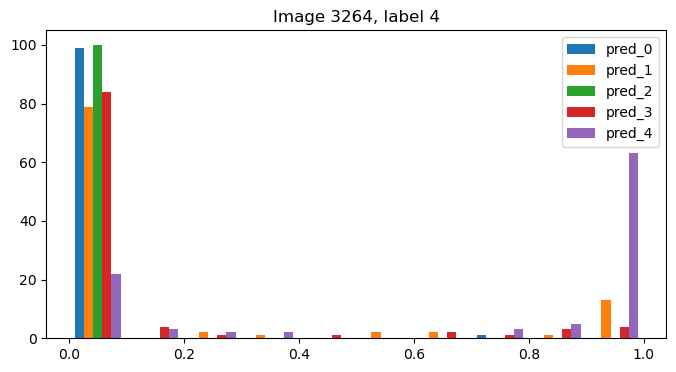

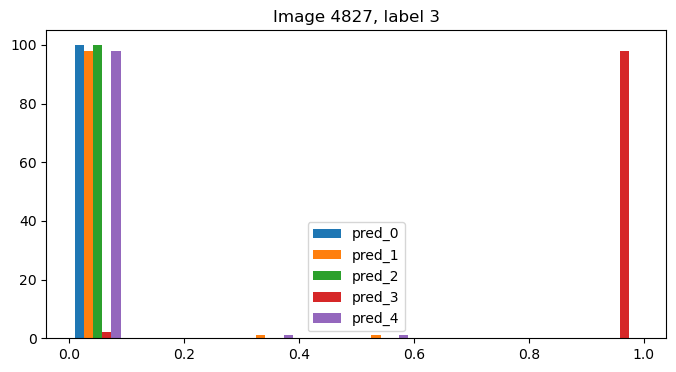

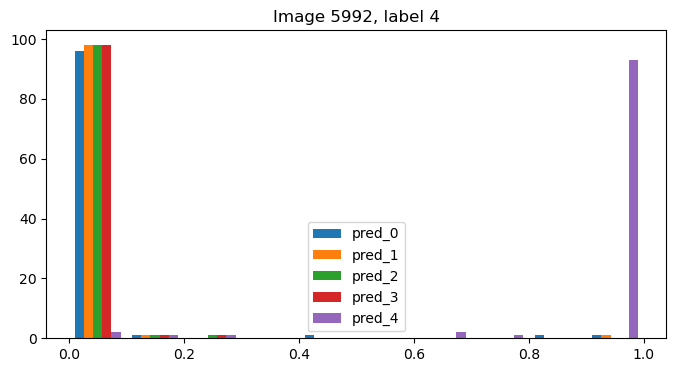

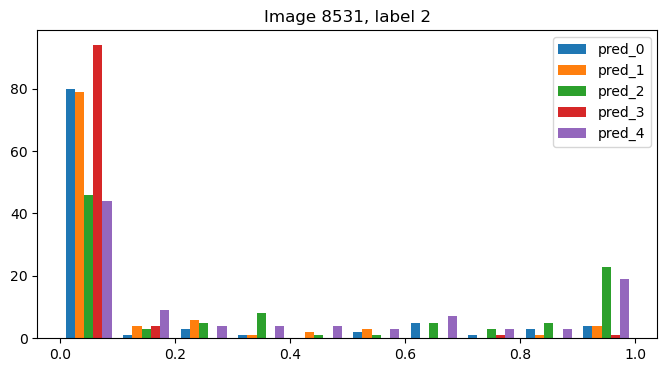

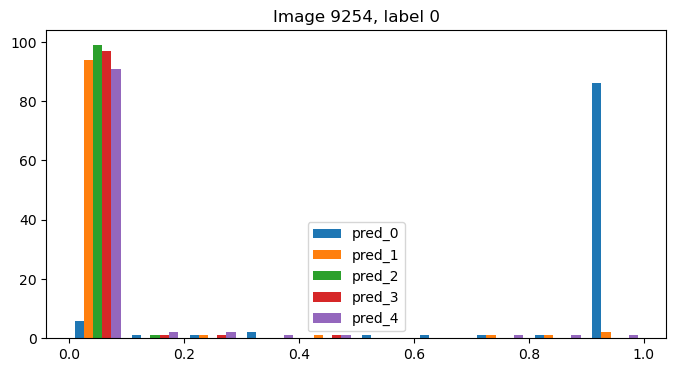

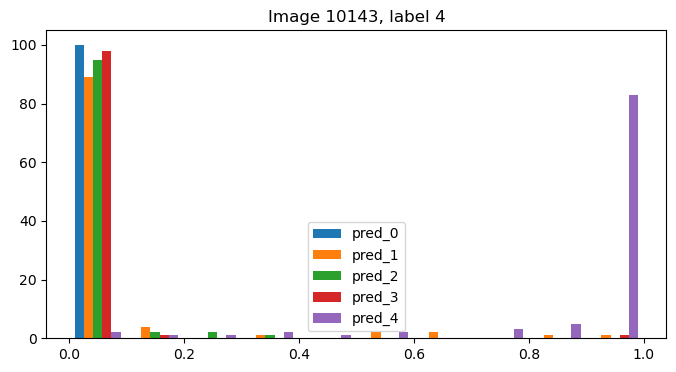

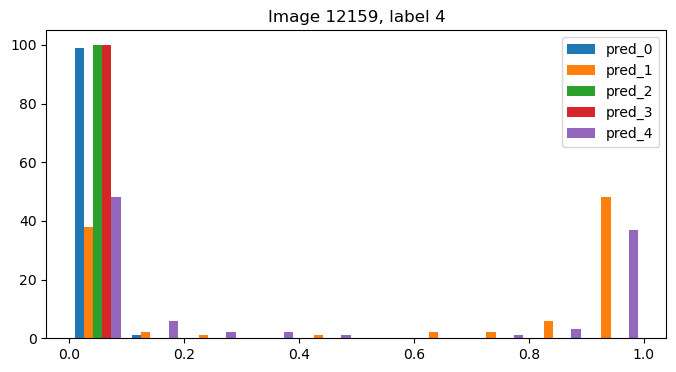

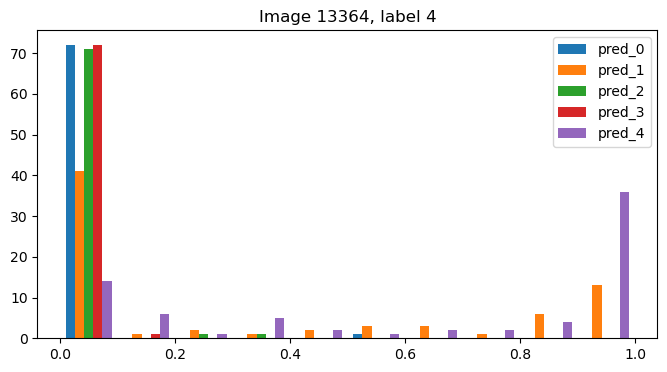

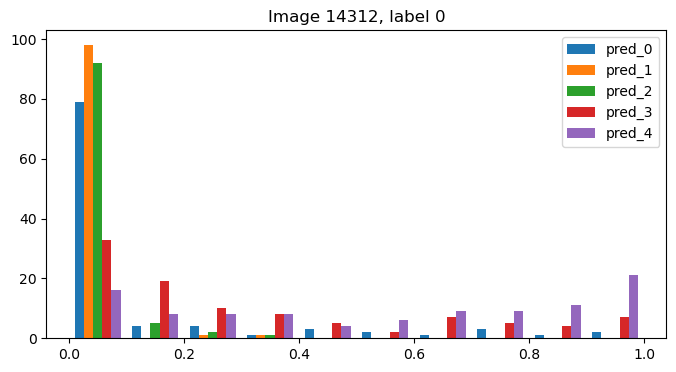

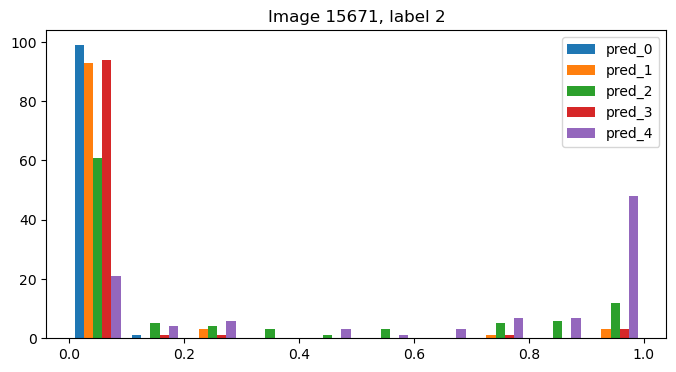

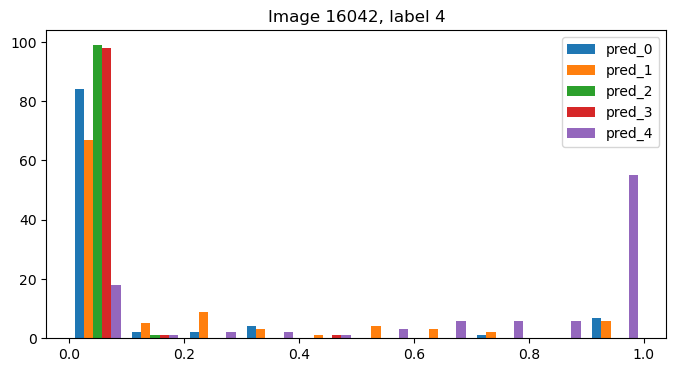

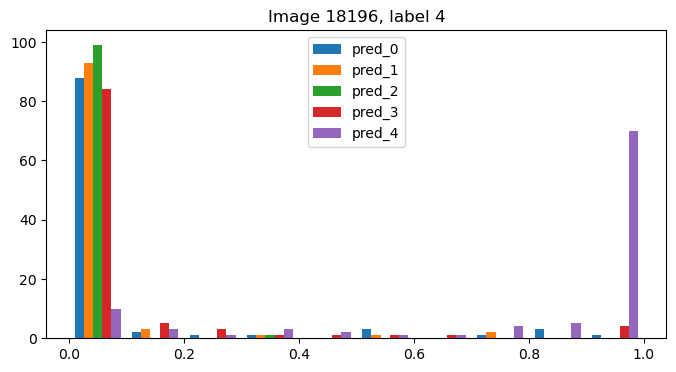

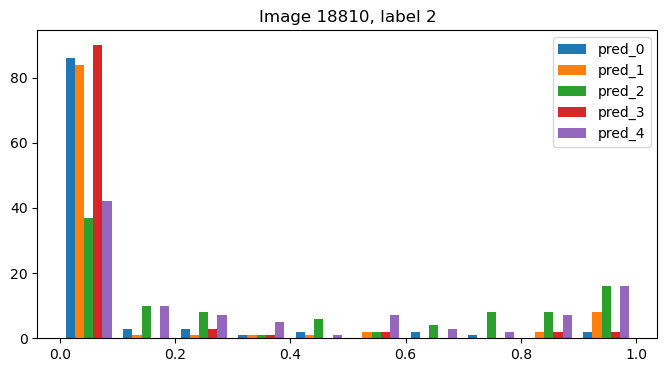

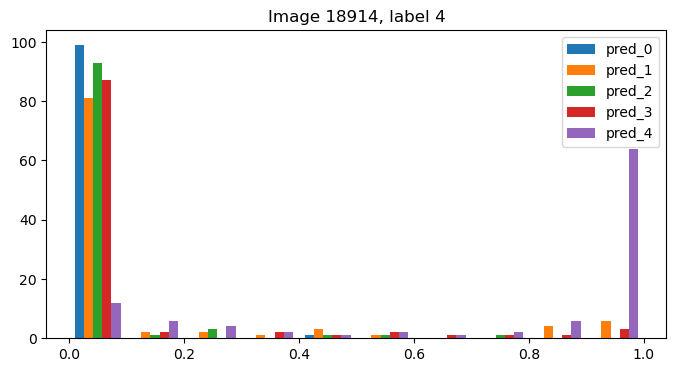

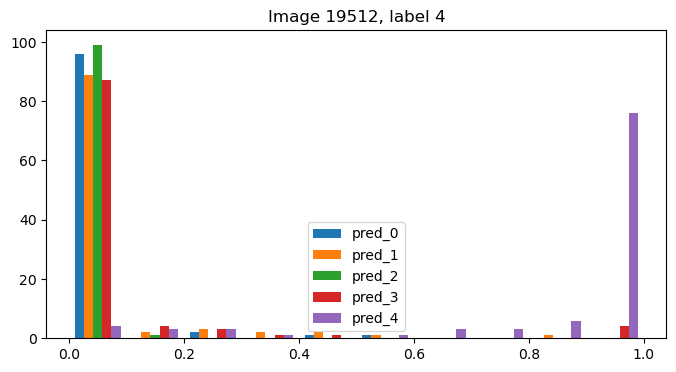

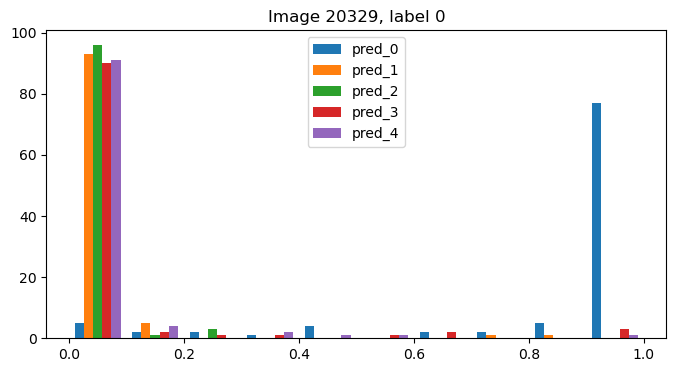

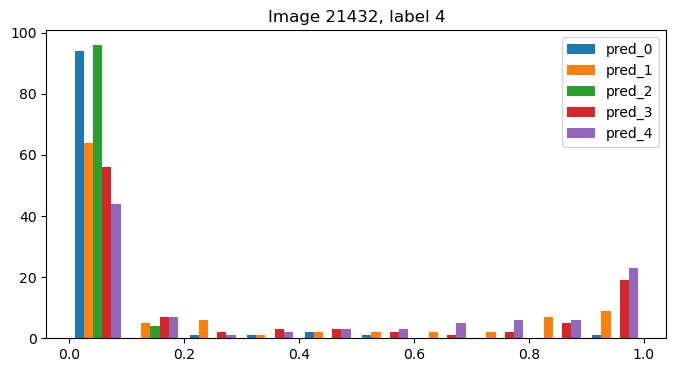

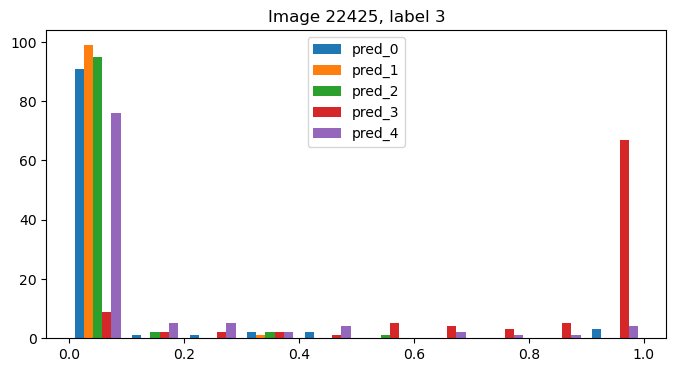

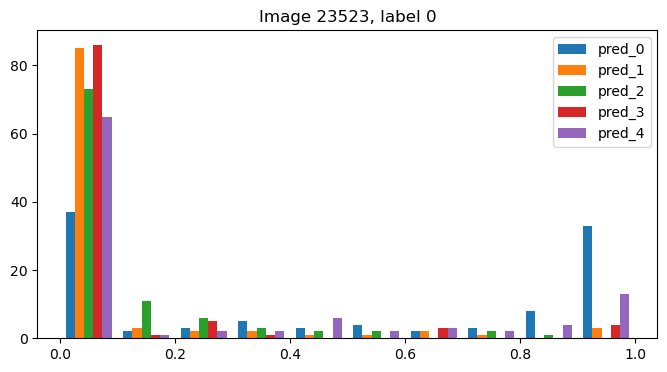

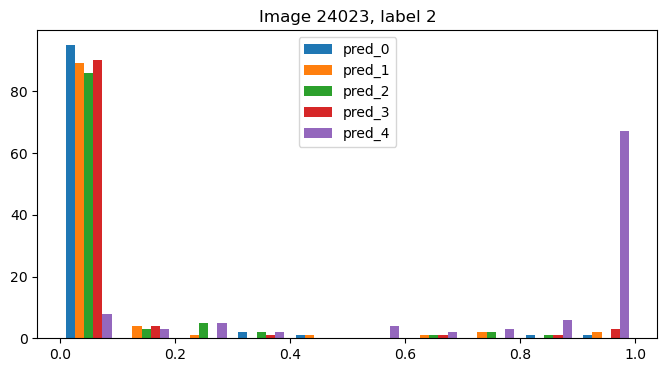

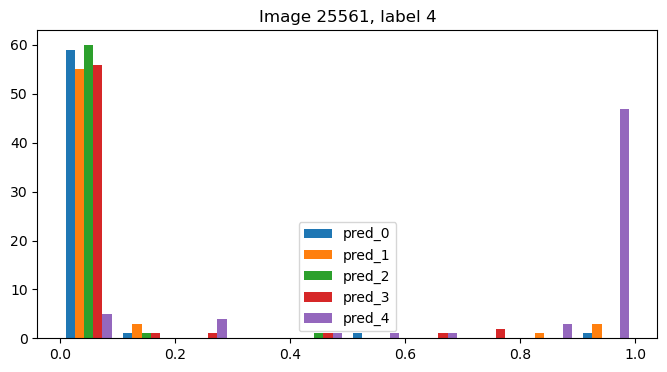

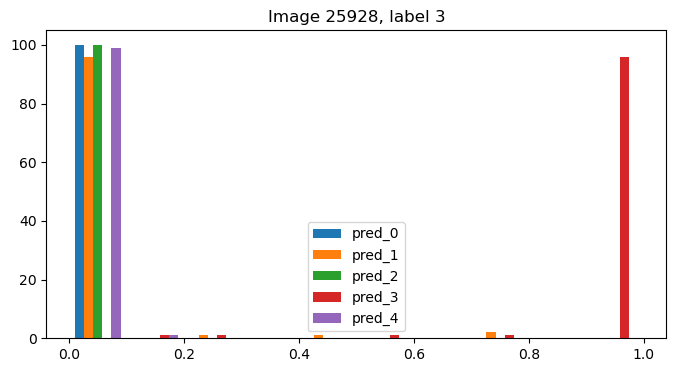

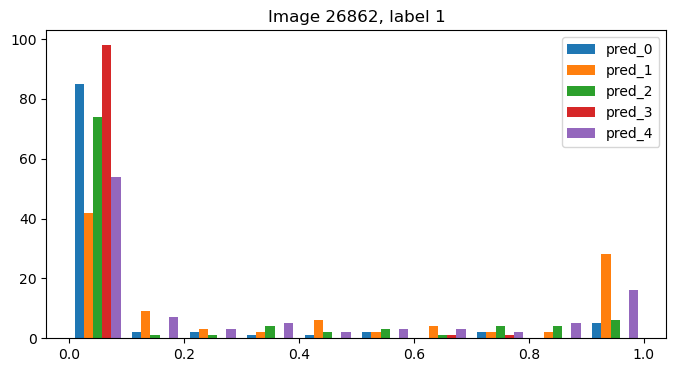

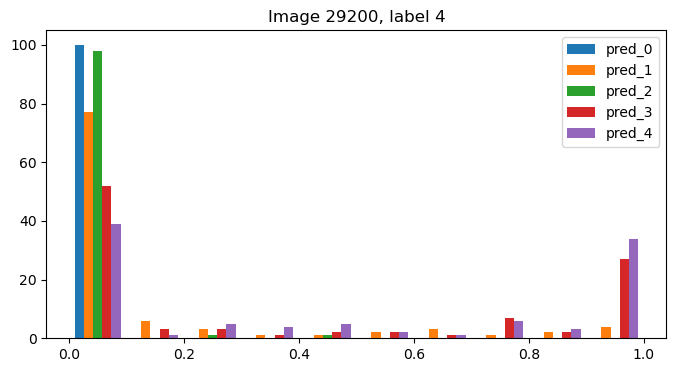

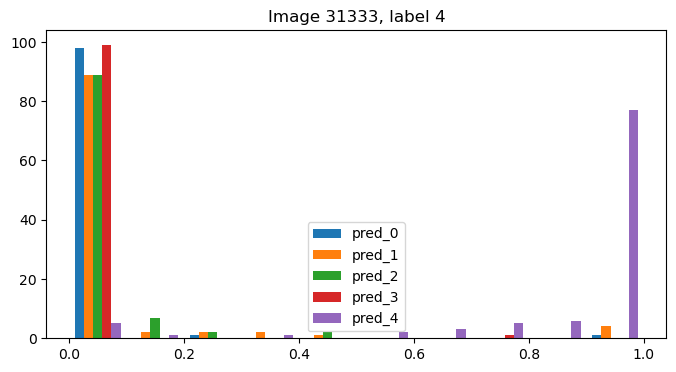

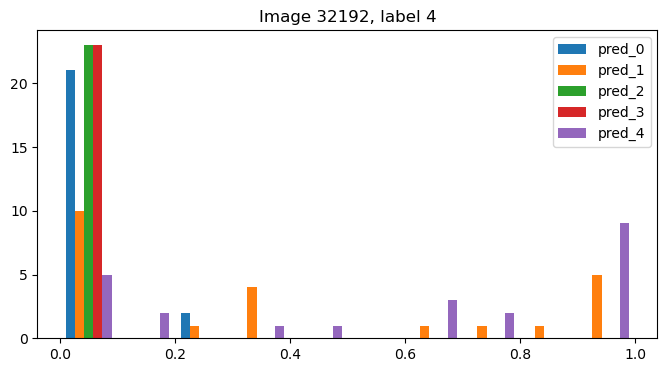

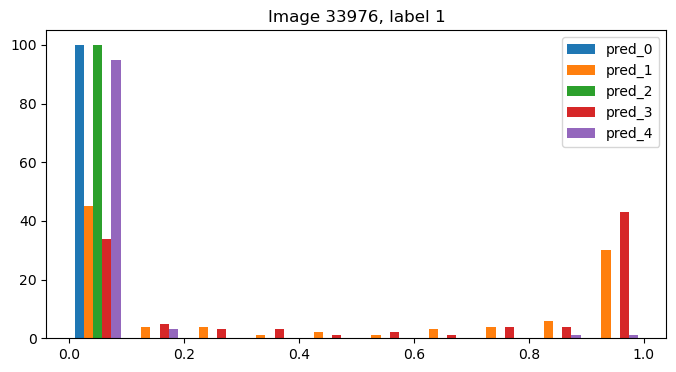

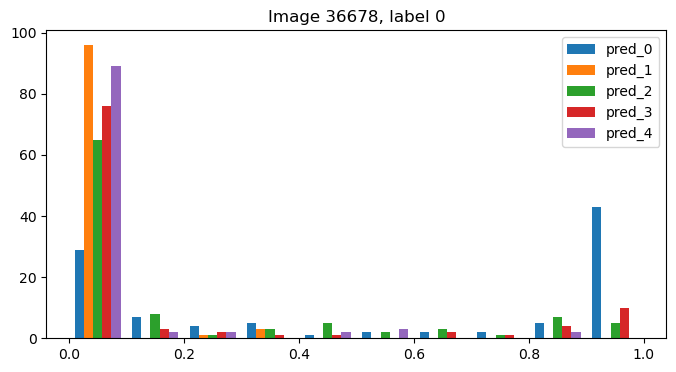

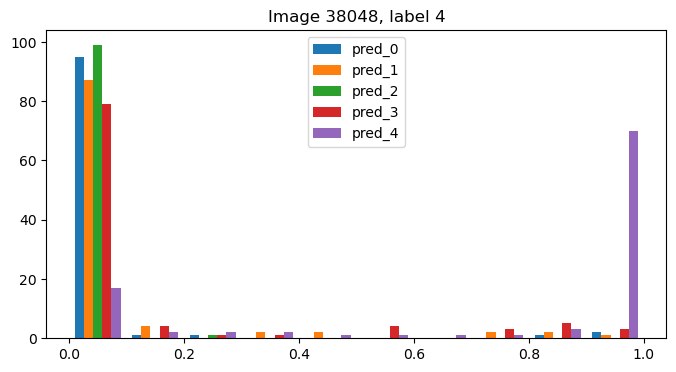

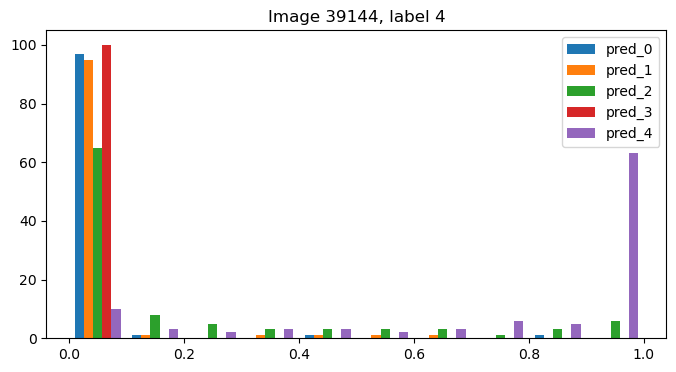

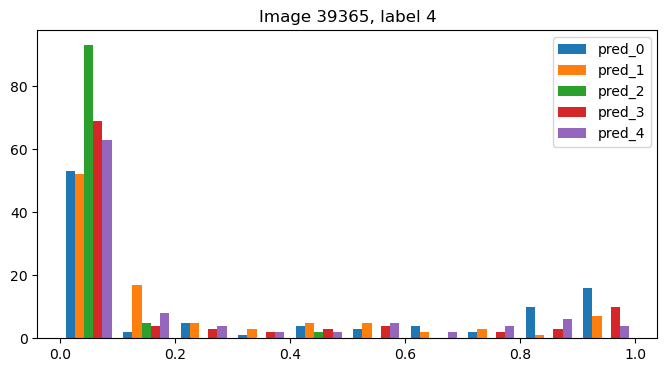

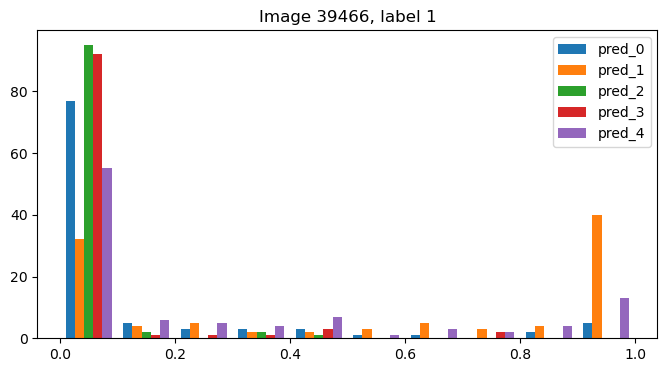

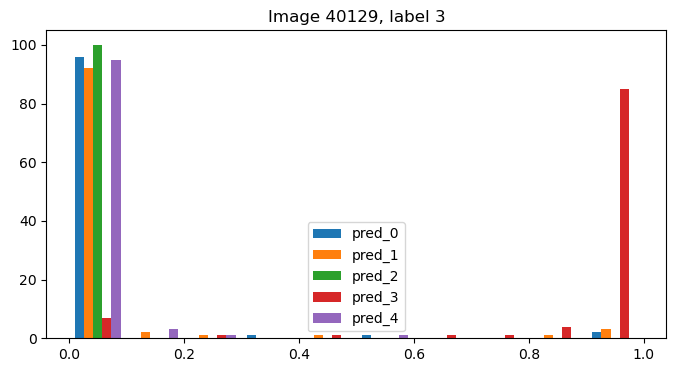

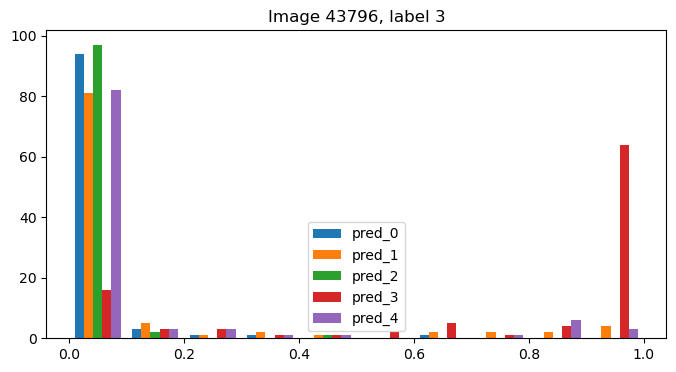

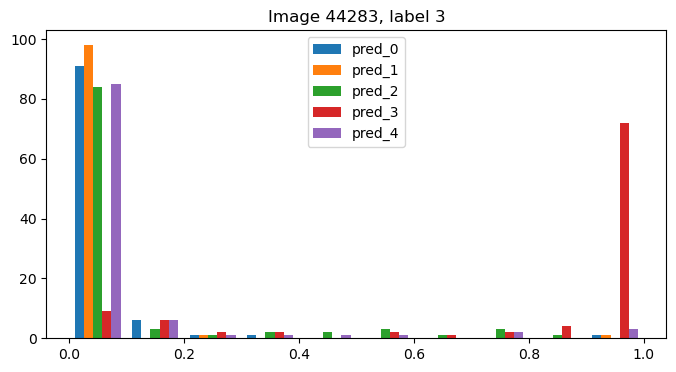

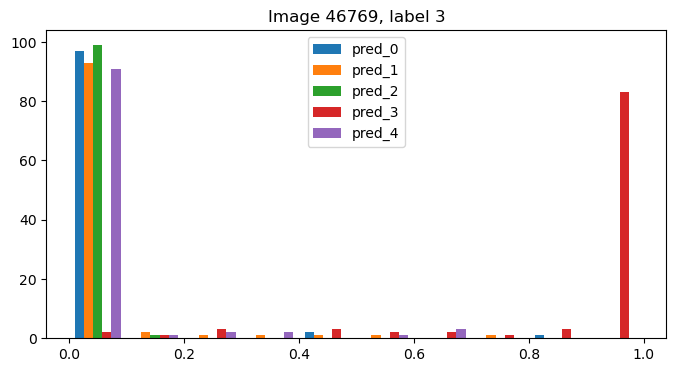

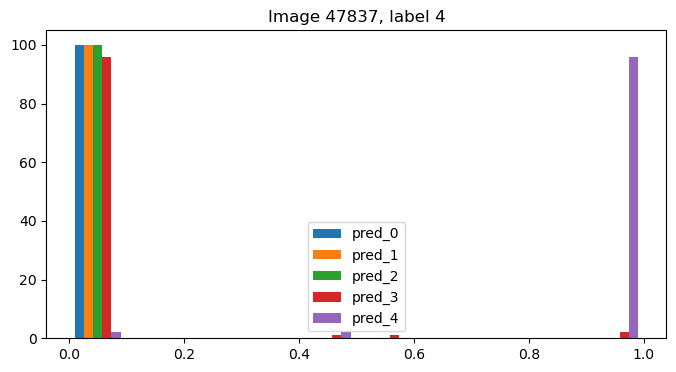

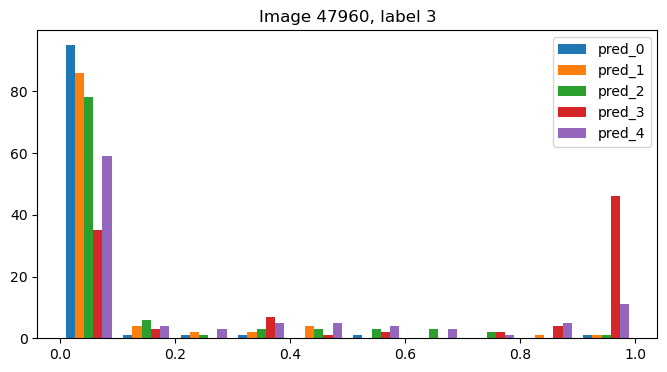

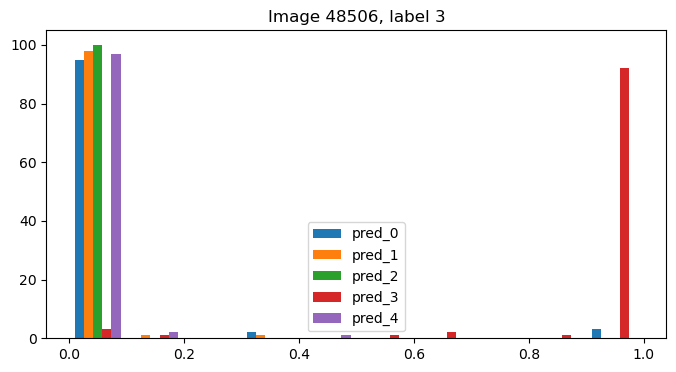

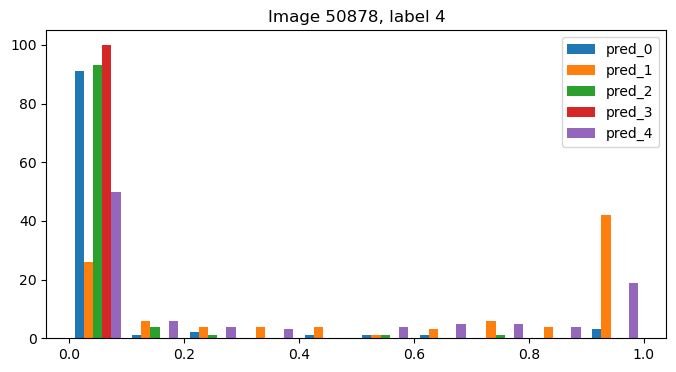

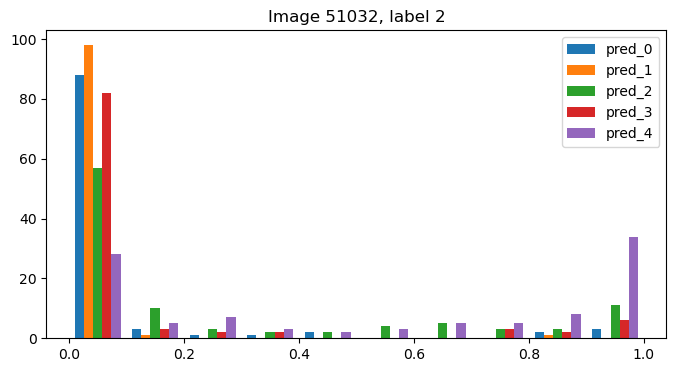

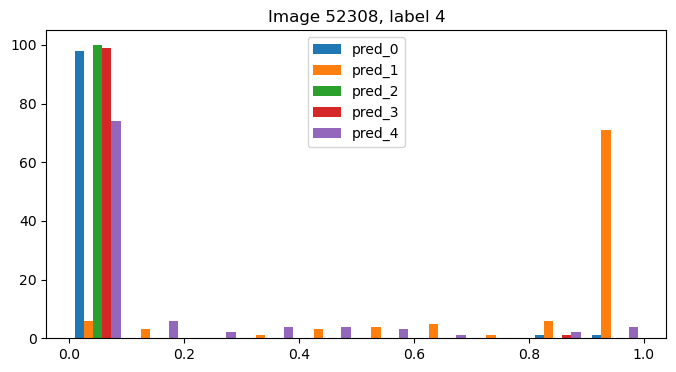

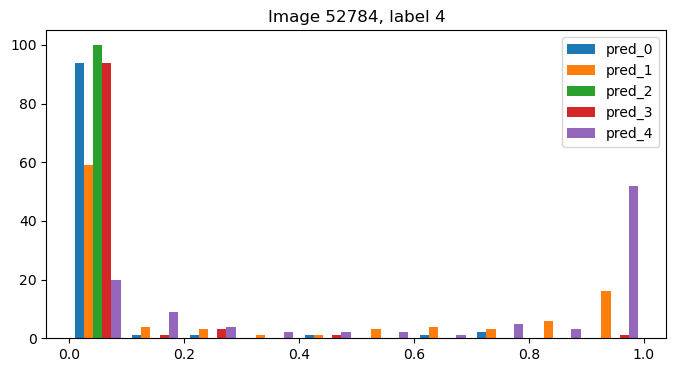

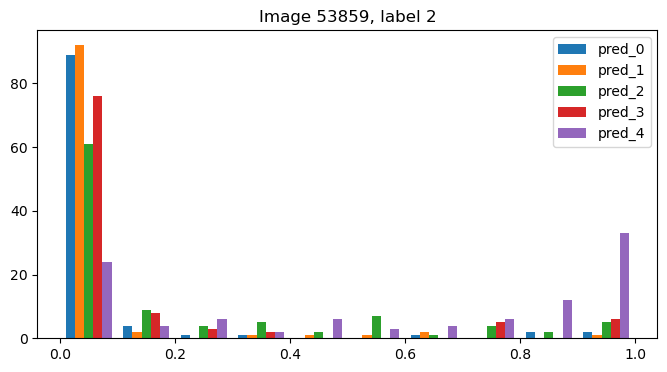

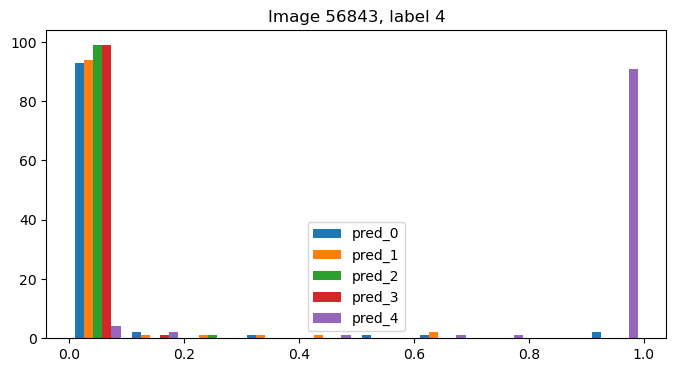

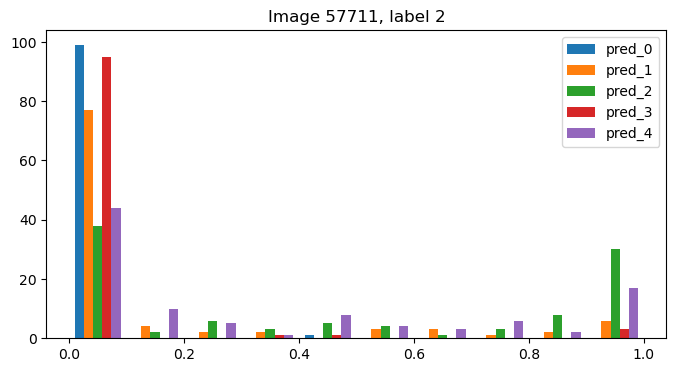

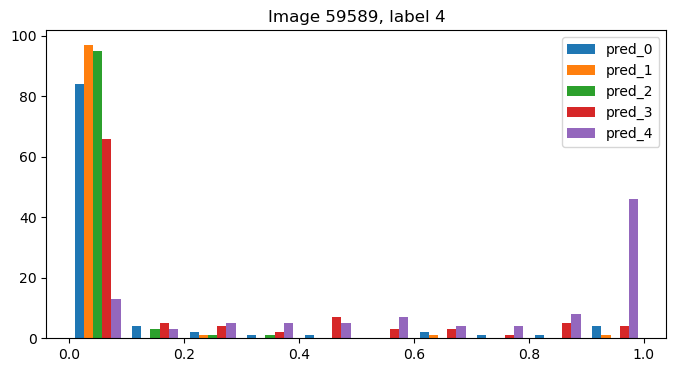

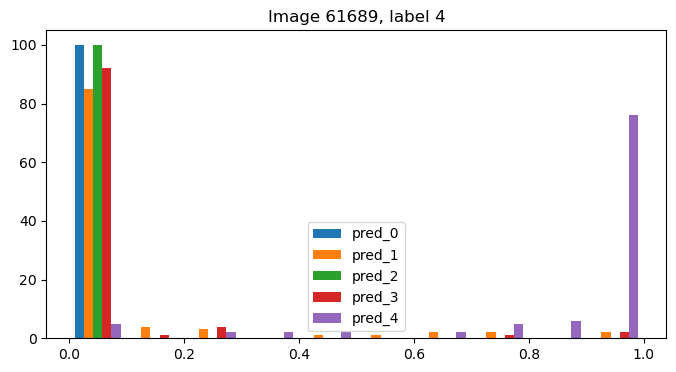

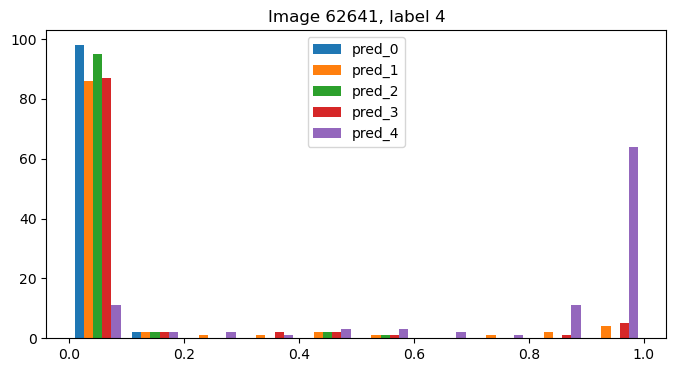

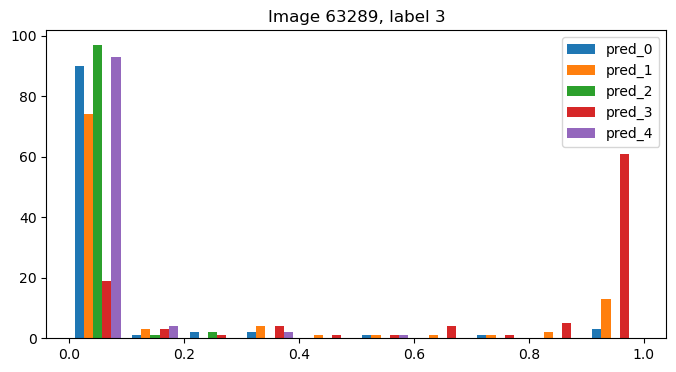

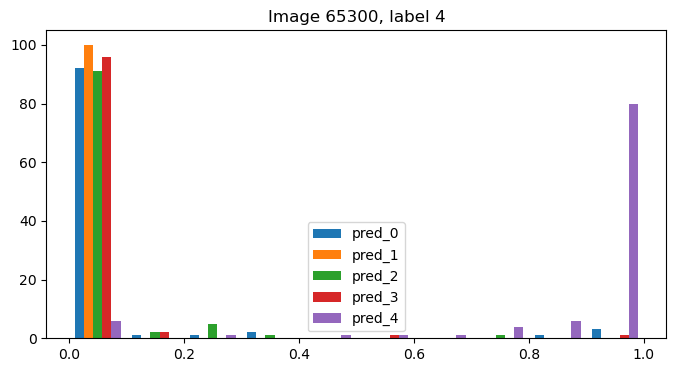

In [39]:
for image_id in pred_df.image_id.unique()[::5]:
    hist_of_preds(image_id)

### Use mode for slide level prediction

In [40]:
pred_cats = []
true_vals = []
for image_id in pred_df.image_id.unique():
    df = pred_df[pred_df.image_id == image_id]
    
    patch_pred = df[['pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4']].to_numpy()
    abs_preds = np.array(patch_pred).argmax(1)
    counts = np.bincount(abs_preds)
    pred_cat = np.argmax(counts)
    
    pred_cats.append(pred_cat)
    true_vals.append(df.label.iloc[0])
    
    print(f'Slide prediction for {image_id} is {pred_cat}. True value is {df.label.iloc[0]}')
print(f'Overall balanced acc: {balanced_accuracy_score(true_vals, pred_cats):.3f}')

Slide prediction for 91 is 0. True value is 4
Slide prediction for 36302 is 3. True value is 3
Slide prediction for 37385 is 1. True value is 1
Slide prediction for 1252 is 4. True value is 4
Slide prediction for 1943 is 1. True value is 3
Slide prediction for 2666 is 4. True value is 2
Slide prediction for 3264 is 4. True value is 4
Slide prediction for 3881 is 1. True value is 4
Slide prediction for 4827 is 3. True value is 3
Slide prediction for 5456 is 0. True value is 0
Slide prediction for 5992 is 4. True value is 4
Slide prediction for 6898 is 1. True value is 1
Slide prediction for 8531 is 2. True value is 2
Slide prediction for 8985 is 4. True value is 1
Slide prediction for 9254 is 0. True value is 0
Slide prediction for 9341 is 4. True value is 4
Slide prediction for 10143 is 4. True value is 4
Slide prediction for 10896 is 4. True value is 4
Slide prediction for 12159 is 1. True value is 4
Slide prediction for 12902 is 0. True value is 2
Slide prediction for 13364 is 4. Tru

Overall balanced acc: 0.668
